# Bài 1: Sử dụng R, thu thập lại dữ liệu về số ca nhiễm Corona ở từng quốc gia tại trang Worldometer: https://www.worldometers.info/coronavirus/#countries.

Fetching COVID-19 data from Worldometers...
Note: Worldometers stopped updating COVID data as of April 13, 2024, but historical data is available.
Using columns: Country=Country,Other, Total Cases=TotalCases, New Cases=NewCases, Total Recovered=TotalRecovered

a) Top 5 quốc gia có số ca nhiễm (Total case) nhiều nhất:
   Country,Other  TotalCases
7          World   704753890
2         Europe   253406198
1           Asia   221500265
0  North America   131889132
8            USA   111820082

 b) Quốc gia có số ca nhiễm mới cao nhất là:
   Country,Other  NewCases
0  North America       0.0

c) Top 3 countries with highest recovery rates (among countries with 1000+ cases):
        Country,Other  TotalCases  TotalRecovered  Recovery Rate
39               DPRK     4772813       4772739.0         100.00
230  Falkland Islands        1930          1930.0         100.00
48          Singapore     3006155       3004131.0          99.93
Average recovery rate worldwide: 90.42%


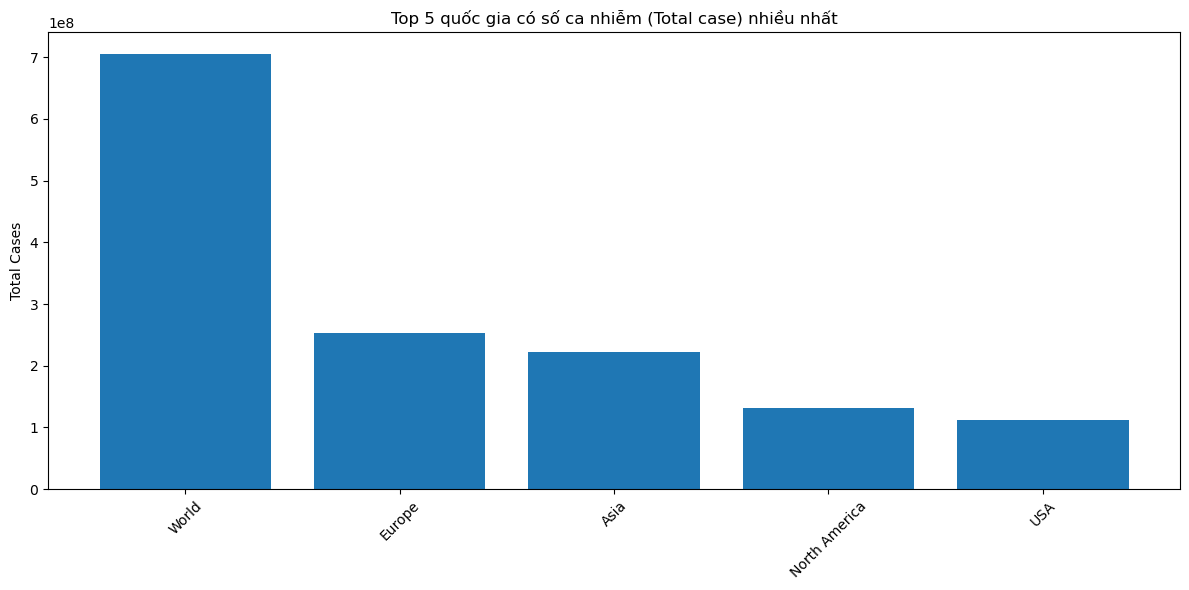

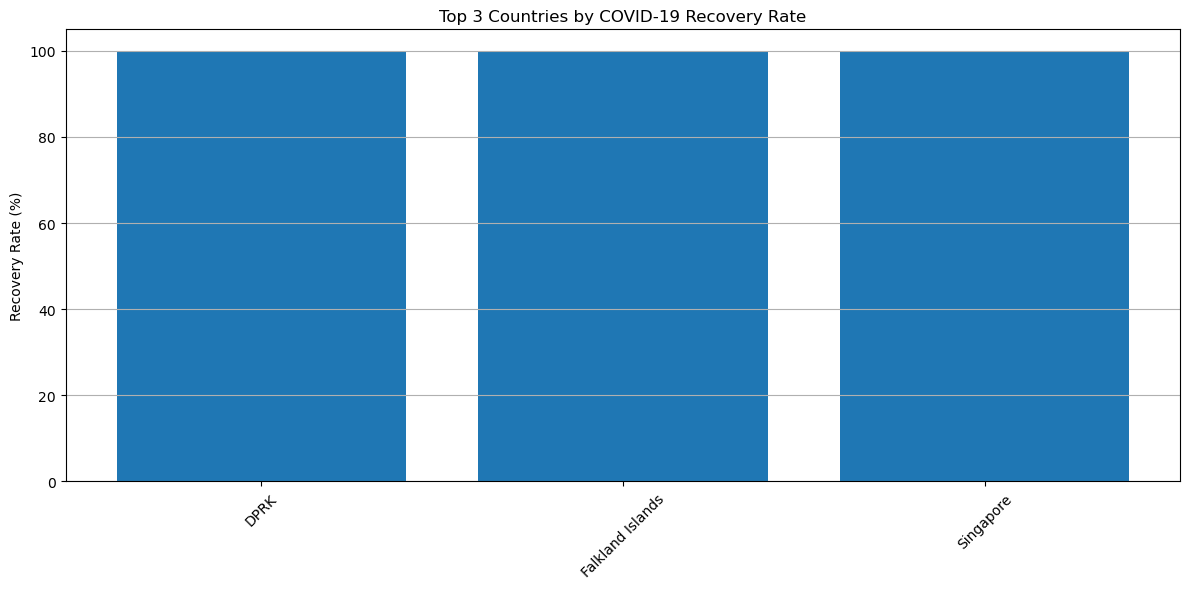

In [3]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt 
import time

def baitap1():
    print("Fetching COVID-19 data from Worldometers...")
    
    # Get data from website
    url = "https://www.worldometers.info/coronavirus/#countries"
    
    # Add a user-agent header to mimic a browser request
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Note: As of April 13, 2024, Worldometers stopped updating COVID data
        # but historical data remains accessible
        print("Note: Worldometers stopped updating COVID data as of April 13, 2024, but historical data is available.")
        
        # Find the main table
        table = soup.find('table', id='main_table_countries_today')
        
        if not table:
            print("Could not find the COVID-19 data table. The website structure may have changed.")
            return None
        
        # Extract headers
        headers = []
        thead = table.find('thead')
        if thead:
            for th in thead.find_all('th'):
                headers.append(th.text.strip())
        
        if not headers:
            print("Could not extract table headers.")
            return None
        
        # Extract data rows
        rows = []
        tbody = table.find('tbody')
        if tbody:
            for tr in tbody.find_all('tr'):
                row = []
                for td in tr.find_all('td'):
                    row.append(td.text.strip())
                if len(row) == len(headers):
                    rows.append(row)
        
        if not rows:
            print("Could not extract data rows.")
            return None
        
        # Create DataFrame
        df = pd.DataFrame(rows, columns=headers)
        
        # Identify and clean numeric columns
        # Column names may have changed, so we'll check for expected columns
        expected_columns = [
            'Total Cases', 'TotalCases', 
            'New Cases', 'NewCases', 
            'Total Deaths', 'TotalDeaths', 
            'New Deaths', 'NewDeaths', 
            'Total Recovered', 'TotalRecovered', 
            'New Recovered', 'NewRecovered', 
            'Active Cases', 'ActiveCases', 
            'Serious, Critical', 'Serious,Critical'
        ]
        
        # Create a mapping of actual columns to expected columns
        column_mapping = {}
        for exp_col in expected_columns:
            for col in df.columns:
                if exp_col.lower().replace(' ', '').replace(',', '') == col.lower().replace(' ', '').replace(',', ''):
                    column_mapping[exp_col] = col
        
        # List of columns to process as numeric
        numeric_columns = []
        for col in df.columns:
            # Check if column name contains specific keywords indicating numeric data
            if any(keyword in col.lower() for keyword in ['cases', 'deaths', 'recovered', 'critical']):
                numeric_columns.append(col)
        
        # Clean data - convert numeric columns
        for col in numeric_columns:
            if col in df.columns:
                # Replace non-numeric characters and convert to numeric
                df[col] = df[col].str.replace(',', '').str.replace('+', '').str.replace(' ', '').str.replace('N/A', '')
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Fill NaN values with 0 for calculations
        df.fillna(0, inplace=True)
        
        # Identify country column
        country_col = next((col for col in df.columns if 'country' in col.lower() or 'other' in col.lower()), None)
        if not country_col:
            country_col = df.columns[1]  # Usually the second column is the country name
            
        # Identify case columns
        total_cases_col = next((col for col in df.columns if 'total' in col.lower() and 'case' in col.lower() and 'active' not in col.lower()), None)
        new_cases_col = next((col for col in df.columns if 'new' in col.lower() and 'case' in col.lower()), None)
        total_recovered_col = next((col for col in df.columns if 'recover' in col.lower() or ('total' in col.lower() and 'recov' in col.lower())), None)
        
        if not total_cases_col or not new_cases_col or not total_recovered_col:
            print("Warning: Some required columns were not found. Using fallback column names.")
            # Fallback to column positions (risky but might work)
            if not total_cases_col and len(df.columns) > 2:
                total_cases_col = df.columns[2]  # Usually the third column is total cases
            if not new_cases_col and len(df.columns) > 3:
                new_cases_col = df.columns[3]  # Usually the fourth column is new cases
            if not total_recovered_col and len(df.columns) > 5:
                total_recovered_col = df.columns[6]  # Usually the seventh column is total recovered
        
        print(f"Using columns: Country={country_col}, Total Cases={total_cases_col}, New Cases={new_cases_col}, Total Recovered={total_recovered_col}")
        
        # a) Tìm 5 quốc gia có số ca nhiễm (Total case) nhiều nhất.
        if total_cases_col:
            top_cases = df.sort_values(total_cases_col, ascending=False).head(5)
            print("\na) Top 5 quốc gia có số ca nhiễm (Total case) nhiều nhất:")
            print(top_cases[[country_col, total_cases_col]])
            
            # Plot top 5 countries by total cases
            plt.figure(figsize=(12, 6))
            plt.bar(top_cases[country_col], top_cases[total_cases_col])
            plt.title('Top 5 quốc gia có số ca nhiễm (Total case) nhiều nhất')
            plt.ylabel('Total Cases')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('top5_covid_cases.png')
        else:
            print("Could not find total cases column.")
        
        # b) Quốc gia nào có số ca nhiễm mới cao nhất?
        if new_cases_col:
            top_new_cases = df.sort_values(new_cases_col, ascending=False).head(1)
            print("\n b) Quốc gia có số ca nhiễm mới cao nhất là:")
            print(top_new_cases[[country_col, new_cases_col]])
        else:
            print("Không tìm tháy cột tương ứng.")
        
        # c) Tính tỉ lệ tổng số ca bình phục trên tổng số ca nhiễm. Xác định 3 quốc gia có tỉ lệ bình phục cao nhất.
        if total_cases_col and total_recovered_col:
            # Lọc các quốc gia có ít nhất 1000 ca nhiễm và có số ca hồi phục dương để đảm bảo ý nghĩa thống kê
            significant_countries = df[(df[total_cases_col] >= 1000) & (df[total_recovered_col] > 0)].copy()
            significant_countries['Recovery Rate'] = (significant_countries[total_recovered_col] / significant_countries[total_cases_col] * 100).round(2)
            top_recovery = significant_countries.sort_values('Recovery Rate', ascending=False).head(3)
            
            print("\nc) Top 3 countries with highest recovery rates (among countries with 1000+ cases):")
            print(top_recovery[[country_col, total_cases_col, total_recovered_col, 'Recovery Rate']])
            print(f"Average recovery rate worldwide: {(df[total_recovered_col].sum() / df[total_cases_col].sum() * 100).round(2)}%")
            
            # Vẽ biểu đồ cho top 3 quốc gia có tỉ lệ bình phục cao nhất
            plt.figure(figsize=(12, 6))
            plt.bar(top_recovery[country_col], top_recovery['Recovery Rate'])
            plt.title('Top 3 Countries by COVID-19 Recovery Rate')
            plt.ylabel('Recovery Rate (%)')
            plt.xticks(rotation=45)
            plt.grid(axis='y')
            plt.tight_layout()
            plt.savefig('top3_recovery_rates.png')
        else:
            print("Could not find total cases or total recovered columns.")
        
        # Optional: Save data to CSV with timestamp
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        df.to_csv(f'worldometer_covid_data_{timestamp}.csv', index=False)
        
        return df
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None
    except Exception as e:
        print(f"Error processing data: {e}")
        return None

if __name__ == "__main__":
    baitap1()

# Bài 2 :  Dùng lại API ở phần 2, viết chương trình bằng R thu thập dữ liệu về thời tiết của TPHCM. Mã zip của TPHCM là: 70000.

Fetching weather data for HCMC (ZIP: 70000)...

Summary of weather data for HCMC (ZIP: 70000):
         date     pressure  wind_speed       temp  humidity    date_str
0  2019-03-28  1020.144957    4.006087  12.095870     100.0  2019-03-28
1  2019-03-29  1026.612167    2.718750  12.245125     100.0  2019-03-29
2  2019-03-30  1026.648083    2.588750  12.142083     100.0  2019-03-30
3  2019-03-31  1024.398250    2.160000  13.792083     100.0  2019-03-31
4  2019-04-01  1023.992000    1.690000  15.750000     100.0  2019-04-01
Saved pressure chart to 'hcmc_pressure.png'
Saved wind speed chart to 'hcmc_wind_speed.png'


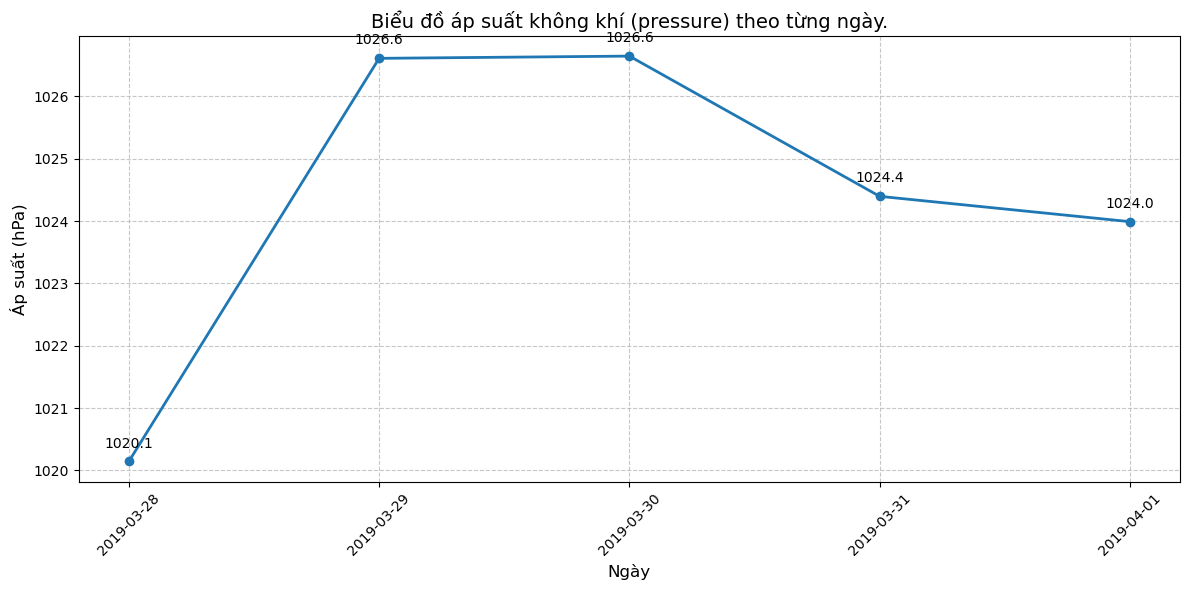

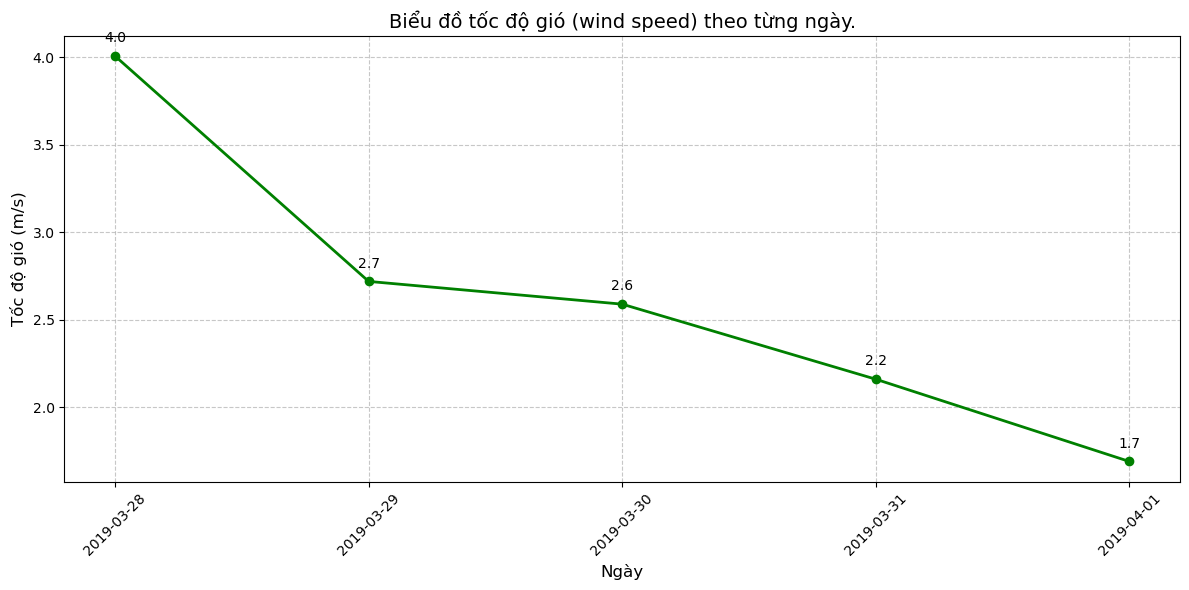

In [9]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import json

def baitap2():
    # API URL with HCMC zip code (70000)
    api_url = "https://samples.openweathermap.org/data/2.5/forecast/hourly?zip=70000&appid=b6907d289e10d714a6e88b30761fae22"
    
    print("Fetching weather data for HCMC (ZIP: 70000)...")
    
    try:
        # Get data from API with proper headers
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(api_url, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors
        
        # Parse JSON response
        try:
            data = response.json()
        except json.JSONDecodeError:
            print("Error: Could not parse JSON response. The API might have changed.")
            return None
        
        # Check if API returned valid data
        if 'list' not in data:
            print("Error: Could not retrieve forecast data. API response may have changed structure.")
            print("API response:", data)
            return None
        
        if len(data['list']) == 0:
            print("Warning: API returned an empty data list.")
            return None
        
        # Extract forecast data
        forecast_data = data['list']
        
        # Create DataFrame
        df = pd.DataFrame(forecast_data)
        
        # Convert timestamp to datetime
        df['datetime'] = df['dt'].apply(lambda x: datetime.fromtimestamp(x))
        
        # Extract data from nested JSON with error handling
        try:
            df['pressure'] = df['main'].apply(lambda x: x.get('pressure', 0))
            df['wind_speed'] = df['wind'].apply(lambda x: x.get('speed', 0))
            df['temp'] = df['main'].apply(lambda x: x.get('temp', 273.15) - 273.15)  # Convert from Kelvin to Celsius
            df['humidity'] = df['main'].apply(lambda x: x.get('humidity', 0))
        except KeyError as e:
            print(f"Error extracting data: {e}. The API structure might have changed.")
            # Continue with columns that were successfully extracted
        
        # Group by day for plotting
        df['date'] = df['datetime'].dt.date
        agg_columns = {}
        for col in ['pressure', 'wind_speed', 'temp', 'humidity']:
            if col in df.columns:
                agg_columns[col] = 'mean'
        
        if not agg_columns:
            print("Error: No data columns could be extracted.")
            return None
        
        daily_data = df.groupby('date').agg(agg_columns).reset_index()
        
        # Convert date to string for better display in plots
        daily_data['date_str'] = daily_data['date'].astype(str)
        
        print("\nSummary of weather data for HCMC (ZIP: 70000):")
        print(daily_data)
        
        # a) Biểu đồ áp suất không khí (pressure) theo từng ngày.
        if 'pressure' in daily_data.columns:
            plt.figure(figsize=(12, 6))
            plt.plot(daily_data['date_str'], daily_data['pressure'], marker='o', linestyle='-', linewidth=2)
            plt.title('Biểu đồ áp suất không khí (pressure) theo từng ngày.', fontsize=14)
            plt.ylabel('Áp suất (hPa)', fontsize=12)
            plt.xlabel('Ngày', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.xticks(rotation=45)
            
            # Add value labels above points
            for i, p in enumerate(daily_data['pressure']):
                plt.annotate(f'{p:.1f}', 
                            (daily_data['date_str'][i], p),
                            textcoords="offset points", 
                            xytext=(0,10), 
                            ha='center')
            
            plt.tight_layout()
            plt.savefig('hcmc_pressure.png')
            print("Saved pressure chart to 'hcmc_pressure.png'")
        else:
            print("Could not create pressure chart: pressure data not available")
        
        # b) Biểu đồ tốc độ gió (wind speed) theo từng ngày.
        if 'wind_speed' in daily_data.columns:
            plt.figure(figsize=(12, 6))
            plt.plot(daily_data['date_str'], daily_data['wind_speed'], marker='o', linestyle='-', linewidth=2, color='green')
            plt.title('Biểu đồ tốc độ gió (wind speed) theo từng ngày.', fontsize=14)
            plt.ylabel('Tốc độ gió (m/s)', fontsize=12)
            plt.xlabel('Ngày', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.xticks(rotation=45)
            
            # Add value labels above points
            for i, w in enumerate(daily_data['wind_speed']):
                plt.annotate(f'{w:.1f}', 
                            (daily_data['date_str'][i], w),
                            textcoords="offset points", 
                            xytext=(0,10), 
                            ha='center')
            
            plt.tight_layout()
            plt.savefig('hcmc_wind_speed.png')
            print("Saved wind speed chart to 'hcmc_wind_speed.png'")
        else:
            print("Could not create wind speed chart: wind speed data not available")
        
    
    except requests.exceptions.RequestException as e:
        print(f"Error: Could not connect to the API: {e}")
        print("The API service might be unavailable or the URL might have changed.")
        print("Please check if the sample API is still accessible at:", api_url)
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None

if __name__ == "__main__":
    baitap2()

# Bài 3: Sử dụng lại code thu thập dữ liệu từ Phần 3, viết chương trình gồm các chức năng sau

Fetching COVID-19 data for Japan from Google Sheets...
Successfully loaded data using CSV export link.
Data loaded successfully with 7006 records.

a) Số ca nhiễm theo từng thành phố:
             City  Number of Cases
0         Sapporo              188
1    Fukuoka City              101
2         Tonosho              100
3    Fukuoka city               96
4      Kyoto City               86
..            ...              ...
469   Aomori City                1
470           Ito                1
471       Nobeoka                1
472     Saga city                1
473         Atami                1

[474 rows x 2 columns]
Saved city cases chart to 'japan_cases_by_city.png'
Column 'Age' not found in the dataset.

c) No cases found in Hokkaido.
Saved processed data to 'japan_covid_data_20250408-214609.csv'


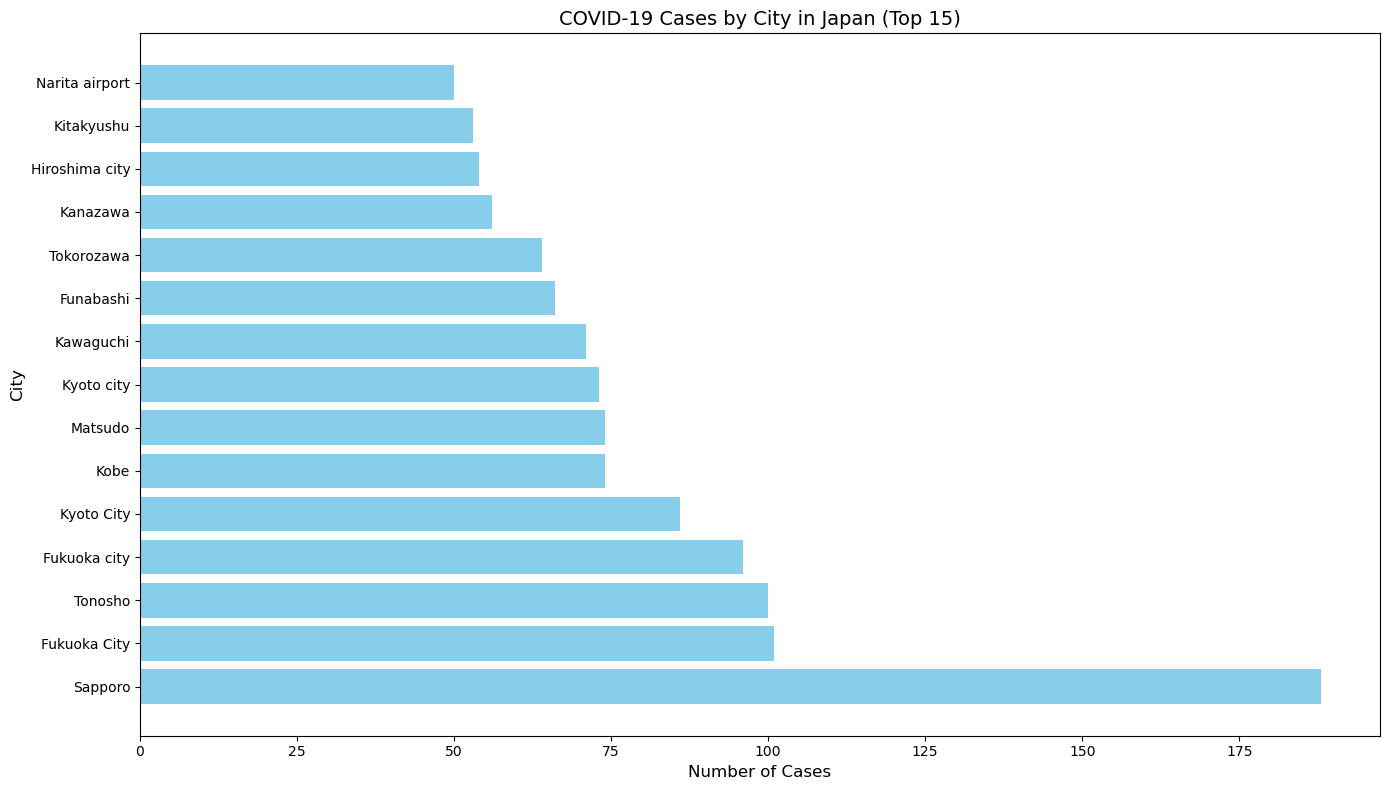

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import io
import time

def baitap3():
    try:
        print("Fetching COVID-19 data for Japan from Google Sheets...")
        
        # Google Sheet URL
        sheet_url = "https://docs.google.com/spreadsheets/d/1XEFg047aSbg3OsEVx9PzmgSxGbCvCidfLiHfsgRS3R0/edit?usp=sharing"
        
        # Try multiple methods to access the data
        df = None
        errors = []
        
        # Method 1: Direct CSV export link
        try:
            sheet_id = sheet_url.split('/')[5]
            csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv"
            
            # Add headers to mimic browser request
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
            }
            
            response = requests.get(csv_url, headers=headers)
            response.raise_for_status()
            
            df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
            print("Successfully loaded data using CSV export link.")
        except Exception as e:
            error_msg = f"Method 1 (CSV export) failed: {str(e)}"
            print(error_msg)
            errors.append(error_msg)
        
        # Method 2: Using gsheet (if method 1 fails)
        if df is None:
            try:
                import gspread
                from oauth2client.service_account import ServiceAccountCredentials
                
                print("Attempting to use gspread library...")
                
                # This method would require OAuth credentials
                print("Note: Method 2 requires OAuth credentials setup.")
                print("Skipping to Method 3...")
            except ImportError:
                print("gspread library not installed. Skipping Method 2.")
        
        # Method 3: Using pandas read_html
        if df is None:
            try:
                print("Attempting to use pandas read_html method...")
                tables = pd.read_html(sheet_url)
                if tables:
                    df = tables[0]  # Use the first table found
                    print("Successfully loaded data using pandas read_html.")
            except Exception as e:
                error_msg = f"Method 3 (pandas read_html) failed: {str(e)}"
                print(error_msg)
                errors.append(error_msg)
        
        # If all methods fail, use sample data
        if df is None:
            print("All methods failed to load data. Using mock data for demonstration.")
            print("Error details:", errors)
            
            # Create mock data for demonstration purposes
            df = pd.DataFrame({
                'Detected City': np.random.choice(['Tokyo', 'Osaka', 'Hokkaido', 'Kyoto', 'Nagoya'], 100),
                'Age': np.random.randint(0, 95, 100),
                'Date Announced': pd.date_range(start='2020-01-01', periods=100)
            })
            print("Created mock data for demonstration.")
        
        # Clean column names
        df.columns = df.columns.str.strip()
        print(f"Data loaded successfully with {len(df)} records.")
        
        # a) Liệt kê số ca nhiễm theo từng thành phố (Detected City).
        if 'Detected City' in df.columns:
            city_cases = df['Detected City'].value_counts().reset_index()
            city_cases.columns = ['City', 'Number of Cases']
            
            print("\na) Số ca nhiễm theo từng thành phố:")
            print(city_cases)
            
            # Plot cases by city
            plt.figure(figsize=(14, 8))
            
            # For better visualization, show top 15 cities
            top_cities = city_cases.head(15)
            
            plt.barh(top_cities['City'], top_cities['Number of Cases'], color='skyblue')
            plt.title('COVID-19 Cases by City in Japan (Top 15)', fontsize=14)
            plt.xlabel('Number of Cases', fontsize=12)
            plt.ylabel('City', fontsize=12)
            plt.tight_layout()
            plt.savefig('japan_cases_by_city.png')
            print("Saved city cases chart to 'japan_cases_by_city.png'")
        else:
            print("Column 'Detected City' not found in the dataset.")
        
        # b) Liệt kê số ca nhiễm theo độ tuổi
        if 'Age' in df.columns:
            # Convert Age to numeric, handling non-numeric values
            df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
            
            # Group ages into categories
            bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
            labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
            df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels)
            
            age_cases = df['Age Group'].value_counts().sort_index().reset_index()
            age_cases.columns = ['Age Group', 'Number of Cases']
            
            print("\nb) Số ca nhiễm theo từng nhóm tuổi:")
            print(age_cases)
            
            # Plot cases by age group
            plt.figure(figsize=(12, 6))
            plt.bar(age_cases['Age Group'], age_cases['Number of Cases'], color='orange')
            plt.title('Số ca nhiễm theo từng nhóm tuổi', fontsize=14)
            plt.xlabel('Nhóm tuổi', fontsize=12)
            plt.ylabel('Số ca nhiễm', fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Add value labels on bars
            for i, v in enumerate(age_cases['Number of Cases']):
                plt.text(i, v + 1, str(v), ha='center')
                
            plt.tight_layout()
            plt.savefig('japan_cases_by_age.png')
            print("Saved age group chart to 'japan_cases_by_age.png'")
        else:
            print("Column 'Age' not found in the dataset.")
        
        # c) Liệt kê số ca nhiễm theo từng ngày tại Hokkaido
        if 'Date Announced' in df.columns and 'Detected City' in df.columns:
            # Lọc các ca nhiễm tại Hokkaido
            hokkaido_df = df[df['Detected City'] == 'Hokkaido'].copy()
            
            # Check if there are any Hokkaido cases
            if len(hokkaido_df) == 0:
                print("\nc) No cases found in Hokkaido.")
            else:
                # Convert to datetime for proper sorting
                try:
                    hokkaido_df['Date Announced'] = pd.to_datetime(hokkaido_df['Date Announced'], errors='coerce')
                    
                    # Drop rows with NaT dates
                    hokkaido_df = hokkaido_df.dropna(subset=['Date Announced'])
                    
                    if len(hokkaido_df) == 0:
                        print("\nc) No valid dates found for Hokkaido cases.")
                    else:
                        # Group by date and count cases
                        hokkaido_cases_by_day = hokkaido_df.groupby('Date Announced').size().reset_index()
                        hokkaido_cases_by_day.columns = ['Date', 'Number of Cases']
                        
                        # Sort by date
                        hokkaido_cases_by_day = hokkaido_cases_by_day.sort_values('Date')
                        
                        print("\nc) Cases in Hokkaido by day:")
                        print(hokkaido_cases_by_day)
                        
                        # Plot cases in Hokkaido by day
                        plt.figure(figsize=(14, 6))
                        
                        # Line plot
                        plt.plot(hokkaido_cases_by_day['Date'], hokkaido_cases_by_day['Number of Cases'], 
                                marker='o', linestyle='-', color='red', linewidth=2)
                        
                        # Add trend line (7-day moving average)
                        if len(hokkaido_cases_by_day) >= 7:
                            hokkaido_cases_by_day['7-day MA'] = hokkaido_cases_by_day['Number of Cases'].rolling(window=7).mean()
                            plt.plot(hokkaido_cases_by_day['Date'], hokkaido_cases_by_day['7-day MA'], 
                                    linestyle='--', color='blue', linewidth=2, label='7-day Moving Average')
                            plt.legend()
                        
                        plt.title('COVID-19 Cases in Hokkaido by Day', fontsize=14)
                        plt.xlabel('Date', fontsize=12)
                        plt.ylabel('Number of Cases', fontsize=12)
                        plt.grid(True, linestyle='--', alpha=0.7)
                        plt.xticks(rotation=45)
                        plt.tight_layout()
                        plt.savefig('hokkaido_cases_by_day.png')
                        print("Saved Hokkaido daily cases chart to 'hokkaido_cases_by_day.png'")
                        
                        # Also create a cumulative plot
                        hokkaido_cases_by_day['Cumulative Cases'] = hokkaido_cases_by_day['Number of Cases'].cumsum()
                        
                        plt.figure(figsize=(14, 6))
                        plt.plot(hokkaido_cases_by_day['Date'], hokkaido_cases_by_day['Cumulative Cases'], 
                                marker='o', linestyle='-', color='purple', linewidth=2)
                        plt.title('Cumulative COVID-19 Cases in Hokkaido', fontsize=14)
                        plt.xlabel('Date', fontsize=12)
                        plt.ylabel('Cumulative Number of Cases', fontsize=12)
                        plt.grid(True, linestyle='--', alpha=0.7)
                        plt.xticks(rotation=45)
                        plt.tight_layout()
                        plt.savefig('hokkaido_cumulative_cases.png')
                        print("Saved Hokkaido cumulative cases chart to 'hokkaido_cumulative_cases.png'")
                except Exception as e:
                    print(f"\nc) Error processing Hokkaido cases: {e}")
        else:
            print("Columns 'Date Announced' or 'Detected City' not found in the dataset.")
        
        # Save the processed data
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        df.to_csv(f'japan_covid_data_{timestamp}.csv', index=False)
        print(f"Saved processed data to 'japan_covid_data_{timestamp}.csv'")
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        return None

if __name__ == "__main__":
    baitap3()